# Regression

In exercise 10, we learned basic signal processing techniques. We will apply those techniques in today's exercise on regression-based EMG signal to hand movement decoding.

Regression is a good candidate for the scenarios where decoding the user's motor intentions in a continuous fashion is desirable. 

The dataset used here is subject1's data in the first database from the Ninapro dataset (https://ninapro.hevs.ch/instructions/DB1.html). 

This dataset includes detailed information about finger angles. Our objective now is to predict these finger angles using the EMG data.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import welch
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

Download the dataset and check the data structure.

In [5]:
data = scipy.io.loadmat('/Users/poseidon/Documents/NSSP/project_2_nssp/data/S1_E1_A1.mat')
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


Now, load in the EMG data. Take only the part of EMG data where the index finger is involved in movements (parte 1 and 2 that correspond to index flexion and index extension, see https://ninapro.hevs.ch/instructions/DB1.html). Check the data structure printing data dimension and type.

In [6]:
emg_data = data["emg"]
print("EMG data dimension: {}".format(emg_data.shape))
print("EMG data type: {}".format(type(emg_data)))

EMG data dimension: (2292526, 16)
EMG data type: <class 'numpy.ndarray'>


Load in hand kinematics labels. Select only the joint angles associated to the index finger movement (5 and 6, see the glove image here https://ninapro.hevs.ch/instructions/DB1.html). Take only the part of data labels where index finger is involved in movement (see cell above). Check the data structure printing data dimension and type.

In [9]:
print(f"Full glove data dimension: {data['glove'].shape}")
selected_joints = [2, 5, 7, 10, 13]  # Joints 3, 6, 8, 11, 14
# Only regressing on finger joint 5 and 6. These are the PIP and DIP joints of the index finger
glove_data_index = data["glove"][:, selected_joints]
print("Glove data dimension: {}".format(glove_data_index.shape))
print("Glove data type: {}".format(type(glove_data_index)))

Full glove data dimension: (2292526, 18)
Glove data dimension: (2292526, 5)
Glove data type: <class 'numpy.ndarray'>


In [11]:
print(f"shape of 5 finger angles: {glove_data_index.shape}")

shape of 5 finger angles: (2292526, 5)


Text(0, 0.5, 'Amplitude')

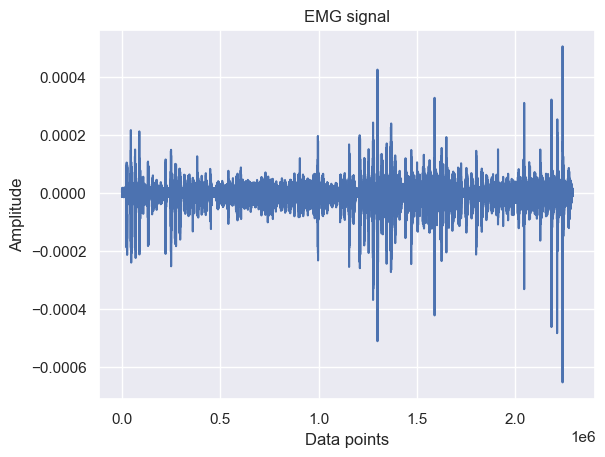

In [17]:
# Plot an EMG channel to get a sense of the data
plt.close("all")
fig, ax = plt.subplots()
ax.plot(emg_data[:, 4])   
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

We can see when the channel is picking up signals from the muscles. Let's check the signal quality to decide on the signal processing techniques.

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

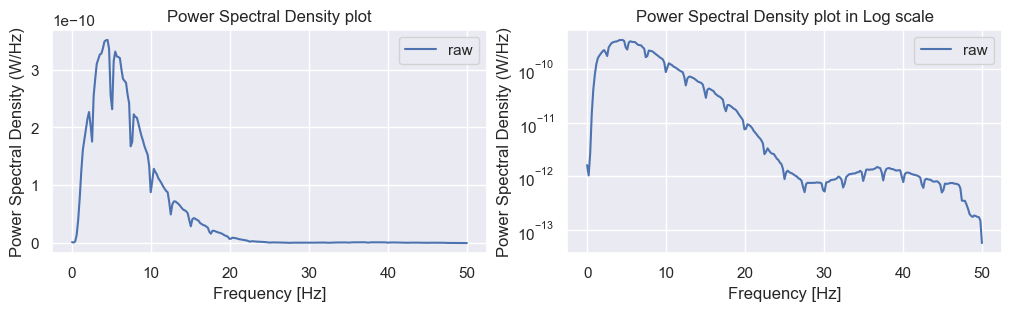

In [18]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.

freqs_pre, Pxx_pre = welch(emg_data[:, 8], fs=100, nperseg=512)
plt.close("all")
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

The signal seems to be minimally influenced by the powerline noise. Therefore, we can save the powerline filtering and proceed directly with the enveloping.

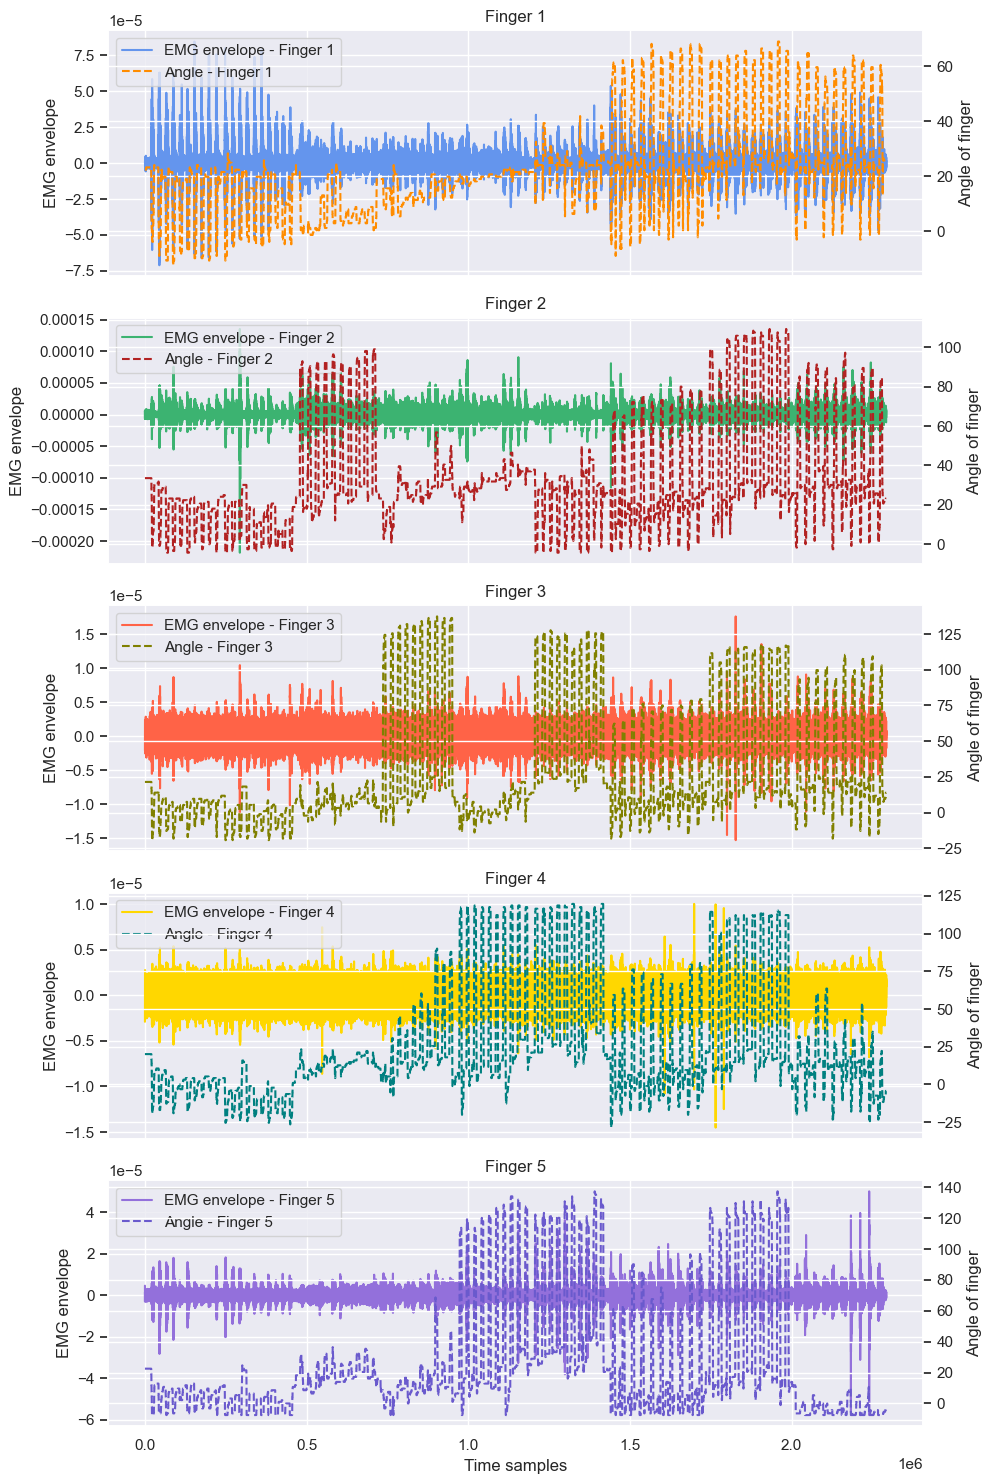

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d

# Assuming emg_data and glove_data_index are already defined
mov_mean_size = 50
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_data, weights=mov_mean_weights, axis=0)

# Define colors for 5 fingers
emg_colors = ['cornflowerblue', 'mediumseagreen', 'tomato', 'gold', 'mediumpurple']
angle_colors = ['darkorange', 'firebrick', 'olive', 'teal', 'slateblue']
finger_labels = ['Finger 1', 'Finger 2', 'Finger 3', 'Finger 4', 'Finger 5']

# Create separate plots for each finger
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

for i, ax in enumerate(axes):
    # Plot EMG envelope
    ax.plot(EMG_envelopes[:, i], color=emg_colors[i], label=f"EMG envelope - {finger_labels[i]}")
    ax.set_ylabel("EMG envelope")
    
    # Create secondary y-axis for angles
    finger_angle_ax = ax.twinx()
    finger_angle_ax.plot(glove_data_index[:, i], color=angle_colors[i], linestyle='--', label=f"Angle - {finger_labels[i]}")
    finger_angle_ax.set_ylabel("Angle of finger")

    # Set title for each subplot
    ax.set_title(f"Finger {i+1}")
    
    # Combine legends for EMG and angles
    emg_handles, emg_labels = ax.get_legend_handles_labels()
    finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()
    combined_handles = emg_handles + finger_angle_handles
    combined_labels = emg_labels + finger_angle_labels
    ax.legend(combined_handles, combined_labels, loc='upper left')

# Add shared x-axis label
axes[-1].set_xlabel("Time samples")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

repetition_data = data['rerepetition'].flatten()

# Normalize the joint angles
scaler = MinMaxScaler()
normalized_joint_angles = scaler.fit_transform(glove_data_index)


# Split data based on repetitions
# Training: repetitions 1-4 and 7-10
train_indices = np.where((repetition_data >= 1) & (repetition_data <= 4) | (repetition_data >= 7) & (repetition_data <= 10))[0]
# Testing: repetitions 5-6
test_indices = np.where((repetition_data >= 5) & (repetition_data <= 6))[0]

# Extract corresponding EMG and joint angle data
train_emg = emg_data[train_indices]
test_emg = emg_data[test_indices]
train_labels = normalized_joint_angles[train_indices]
test_labels = normalized_joint_angles[test_indices]

# Split training data into training and validation sets
val_size = 0.2  # 20% of the training data for validation
val_end = int(val_size * train_emg.shape[0])

train_emg_set = train_emg[:-val_end]
val_emg_set = train_emg[-val_end:]
train_labels_set = train_labels[:-val_end]
val_labels_set = train_labels[-val_end:]

# Print the sizes of the splits
print(f"Training EMG data size: {train_emg_set.shape}")
print(f"Validation EMG data size: {val_emg_set.shape}")
print(f"Test EMG data size: {test_emg.shape}")
print(f"Training Labels size: {train_labels_set.shape}")
print(f"Validation Labels size: {val_labels_set.shape}")
print(f"Test Labels size: {test_labels.shape}")


Training EMG data size: (1465799, 16)
Validation EMG data size: (366449, 16)
Test EMG data size: (450400, 16)
Training Labels size: (1465799, 5)
Validation Labels size: (366449, 5)
Test Labels size: (450400, 5)


To process the dataset efficiently, we divide it into overlapping sliding windows. This approach allows us to extract smaller segments of the EMG data, each corresponding to a specific time interval. The sliding window technique ensures that we capture temporal patterns in the signal by dividing it into time segments, while maintaining continuity through overlapping segments.

In [21]:
fs = 100  # [Hz], from dataset description
emg_window_length_sec = 200e-3  # [s]
incremental_window_length_sec = 40e-3  # [s]

In [22]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [23]:
# Extract overlapping time windows on train set and test set
EMG_train_windows, Labels_train_windows = extract_time_windows_regression(
    train_emg_set, train_labels_set, fs, emg_window_length_sec, incremental_window_length_sec
)
EMG_val_windows, Labels_val_windows = extract_time_windows_regression(
    val_emg_set, val_labels_set, fs, emg_window_length_sec, incremental_window_length_sec
)
EMG_test_windows, Labels_test_windows = extract_time_windows_regression(
    test_emg, test_labels, fs, emg_window_length_sec, incremental_window_length_sec
)

# Print the shapes of the resulting datasets
print(f"EMG train windows shape: {EMG_train_windows.shape}, Train label windows shape: {Labels_train_windows.shape}")
print(f"EMG validation windows shape: {EMG_val_windows.shape}, Validation label windows shape: {Labels_val_windows.shape}")
print(f"EMG test windows shape: {EMG_test_windows.shape}, Test label windows shape: {Labels_test_windows.shape}")


EMG train windows shape: (366445, 20, 16), Train label windows shape: (366445, 20, 5)
EMG validation windows shape: (91608, 20, 16), Validation label windows shape: (91608, 20, 5)
EMG test windows shape: (112595, 20, 16), Test label windows shape: (112595, 20, 5)


Now that we have the windows, lets extract some features again. For this exercise, we will just look at the simple features: mean, std and max amplitude of the windows.

In [24]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean, standard deviation, and max amplitude of each window and the mean of the labels window
    """
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows,axis=1)
    EMG_std = np.std(EMG_windows,axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)
    Labels_mean = np.mean(Labels_windows,axis=1)
    
    # Concatenate the mean and std of each window
    EMG_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude), axis=1)
    return EMG_extracted_features, Labels_mean

In [25]:
# Extract features from train, validation, and test windows
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows, Labels_train_windows)
EMG_val_extracted_features, Labels_val_mean = extract_features(EMG_val_windows, Labels_val_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows, Labels_test_windows)

# Print the shapes of the extracted features and labels
print("EMG train extracted features shape: {}, Finger labels feature shape: {}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG validation extracted features shape: {}, Finger labels feature shape: {}".format(EMG_val_extracted_features.shape, Labels_val_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape: {}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))


EMG train extracted features shape: (366445, 48), Finger labels feature shape: (366445, 5)
EMG validation extracted features shape: (91608, 48), Finger labels feature shape: (91608, 5)
EMG test extracted features shape: (112595, 48), Finger labels feature shape: (112595, 5)


Next, we'll focus on the regressor. Scikit-learn greatly simplifies the process, whether you're working with classification or regression tasks. The key is ensuring your data is in a format compatible with the library. Once that's achieved, switching between different algorithm types to suit your data becomes straightforward. The workflow is quite similar across various algorithms: you start by fitting the model to your training data, and then proceed to make predictions on the test set.

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

# Standardize the features for SVM
scaler = StandardScaler()
EMG_train_extracted_features_scaled = scaler.fit_transform(EMG_train_extracted_features)
EMG_test_extracted_features_scaled = scaler.transform(EMG_test_extracted_features)

# Use MultiOutputRegressor to handle multi-output regression with SVR
svm_regressor = MultiOutputRegressor(SVR(kernel='rbf', C=1.0, epsilon=0.1))  # You can tune the kernel, C, and epsilon parameters
svm_regressor.fit(EMG_train_extracted_features_scaled, Labels_train_mean)

# Predict using the multi-output SVR
y_pred_svm = svm_regressor.predict(EMG_test_extracted_features_scaled)

# Print results or evaluate
print("Predictions using SVM:", y_pred_svm)

It's crucial to quantify the model's performance using appropriate metrics. Take a look at scikit-learn's model evaluation (https://scikit-learn.org/stable/modules/model_evaluation.html), there are many metrics that we can choose. The more common ones are MSE, RMSE, MAE. For this exercise, we can take a look at MSE. 

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Compute the Mean Squared Error (MSE)
MoR_MSE = mean_squared_error(Labels_test_mean, y_pred_svm)

# Compute the Root Mean Squared Error (RMSE)
MoR_RMSE = np.sqrt(MoR_MSE)

# Compute the R² score
MoR_R2 = r2_score(Labels_test_mean, y_pred_svm)

# Print the results
print(f'MSE of SVM: {MoR_MSE}')
print(f'RMSE of SVM: {MoR_RMSE}')
print(f'R² score of SVM: {MoR_R2}')

MSE of Random Forest: 548.5861098581028


Check prediction accuracy in finger angle 5 and 6:

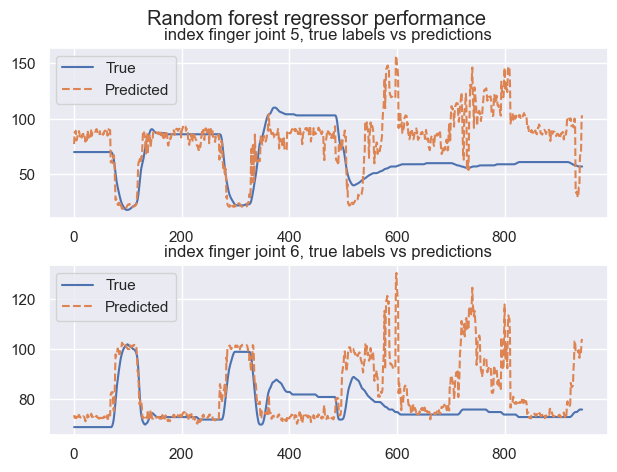

In [ ]:
plt.close("all")

# Number of finger joints to plot
num_fingers = 5

# Create a figure with dynamically generated subplots
fig, ax = plt.subplots(num_fingers, 1, figsize=(8, 2 * num_fingers))
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle("Random Forest Regressor Performance for 5 Fingers")

# Loop through each finger and plot true vs predicted values
for i in range(num_fingers):
    ax[i].plot(Labels_test_mean[:, i], label="True", color="cornflowerblue")
    ax[i].plot(y_pred_svm[:, i], linestyle="--", label="Predicted", color="darkorange")
    ax[i].set_title(f"Finger joint {i + 1}, true labels vs predictions")
    ax[i].legend()

# Show the plot
plt.show()

By itself, the values might not seem that meaningful (if you're very familiar with the domain of your analysis, you might get a sensing of how good the MSE is). Unlike classification's accuracy, regression usually require more context or comparison. Let's try to compare 3 different algorithm and evaluate the MSE.